# BTC Stochastic + Mining Cost Models/Backtest 

Implemented two models:
1. **Mining Cost model** tuned to beat BTC buy-and-hold by a small Sharpe margin.
2. **OU stochastic mean-reversion model** with simple parameter search.


In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

TRADING_DAYS = 365

def sharpe_ratio(daily_returns: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    r = daily_returns.dropna()
    if len(r) < 2:
        return float("nan")

    vol = r.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return float("nan")

    return float((r.mean() / vol) * np.sqrt(trading_days))


In [50]:
def _clean_numeric_series(s: pd.Series) -> pd.Series:
    """Convert strings with commas/%/$ to float when possible."""
    if s.dtype == "O":
        s2 = (
            s.astype(str)
             .str.replace(",", "", regex=False)
             .str.replace("$", "", regex=False)
             .str.replace("%", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(s2, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def _find_first_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def read_price_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 1) date column
    date_col = _find_first_col(df, ["End", "Start", "Date", "timestamp", "Datetime", "Time", "time"])
    if date_col is None:
        raise ValueError(f"Cannot find a date column in {path.name}. Columns: {list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # 2) normalize column names we care about
    # some files use Price instead of Close (IBIT)
    close_col = _find_first_col(df, ["Close", "Price", "Adj Close", "AdjClose", "close", "price"])
    if close_col is None:
        raise ValueError(f"Cannot find a close/price column in {path.name}. Columns: {list(df.columns)}")

    # convert key numeric columns if present
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c]) if df[c].dtype == "O" else df[c]

    # unify to standard OHLC if missing
    if "Close" not in df.columns:
        df["Close"] = df[close_col].astype(float)

    # if Open/High/Low exist, clean them too
    for c in ["Open", "High", "Low", "Volume", "Market Cap", "CVol"]:
        if c in df.columns:
            df[c] = _clean_numeric_series(df[c])

    return df

def read_mining_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # find a timestamp-like column
    ts_col = _find_first_col(df, ["timestamp", "Timestamp", "date", "Date", "time", "Time"])
    if ts_col is None:
        # your mining file may have multiple timestamp cols; brute force fallback
        ts_candidates = [c for c in df.columns if str(c).lower() == "timestamp"]
        if ts_candidates:
            ts_col = ts_candidates[0]
        else:
            raise ValueError(f"No timestamp column found in {path.name}. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).set_index(ts_col)

    # drop duplicate columns + unnamed
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, [c for c in df.columns if not str(c).lower().startswith("unnamed")]]

    # clean numerics where possible
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c])

    return df


In [ ]:
# ---------- Cell 3 (load + clean CSV inputs) ----------
# This cell intentionally reuses the robust helper functions from Cell 2.
# We only handle path discovery + orchestration here.

from pathlib import Path

# Resolve repository root robustly.
# Why this is needed:
# - In Jupyter, the working directory may be project root OR /Crypto OR another parent.
# - Using only one relative path can silently break and leave later outputs empty.

def _find_data_dir() -> Path:
    """Locate 'Market Data/Crypto Data' from common execution locations."""
    cwd = Path.cwd().resolve()
    candidates = []

    # Try cwd and its parents.
    for base in [cwd, *cwd.parents]:
        candidates.append(base / "Market Data" / "Crypto Data")

    # Try notebook-folder-relative fallback (when cwd is elsewhere).
    candidates.append(Path("/workspace/LunaExchange") / "Market Data" / "Crypto Data")

    # Keep your original absolute path as a final fallback.
    candidates.append(Path("/Users/samgeng14/PycharmProjects/LunaExchange/Market Data/Crypto Data"))

    for c in candidates:
        if c.exists():
            return c

    raise FileNotFoundError(
        "Could not locate 'Market Data/Crypto Data'. Tried: " + ", ".join(str(c) for c in candidates)
    )

DATA_DIR = _find_data_dir()

FILES = {
    "btc": DATA_DIR / "BTC.csv",
    "ibit": DATA_DIR / "IBIT.csv",
    "etha": DATA_DIR / "ETHA.csv",
    "btc_mining": DATA_DIR / "BTC_Mining_Cost.csv",
}

missing_files = [name for name, path in FILES.items() if not path.exists()]
if missing_files:
    raise FileNotFoundError(
        f"Missing required CSV files: {missing_files}. Resolved DATA_DIR={DATA_DIR}"
    )

# Read and clean all sources with shared parsing helpers.
btc = read_price_csv(FILES["btc"])
ibit = read_price_csv(FILES["ibit"])
etha = read_price_csv(FILES["etha"])
btc_mining_raw = read_mining_csv(FILES["btc_mining"])

# Extra cleanup for mining data.
btc_mining_raw = (
    btc_mining_raw[~btc_mining_raw.index.duplicated(keep="last")]
    .sort_index()
    .dropna(axis=1, how="all")
)

print(f"Using DATA_DIR: {DATA_DIR}")
print(f"Loaded BTC rows: {len(btc):,}")
print(f"Loaded BTC mining rows: {len(btc_mining_raw):,}")

display(btc.tail())
display(btc_mining_raw.tail())


In [52]:
def to_daily_close(df: pd.DataFrame, close_col="Close") -> pd.Series:
    s = df[close_col].copy()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    s = s.asfreq("D").ffill()
    return s

btc_close = to_daily_close(btc, "Close")

btc_mining = btc_mining_raw.copy()
btc_mining = btc_mining[~btc_mining.index.duplicated(keep="last")].sort_index()
btc_mining = btc_mining.asfreq("D").ffill()

df_btc = pd.DataFrame({"close": btc_close}).join(btc_mining, how="left").ffill()

display(df_btc[["close"]].tail())


,close
1970-01-01,NaN


In [53]:
def btc_block_reward(date_index: pd.DatetimeIndex) -> pd.Series:
    r = pd.Series(index=date_index, dtype=float)
    r.loc[:] = 50.0
    r.loc[r.index >= pd.Timestamp("2012-11-28")] = 25.0
    r.loc[r.index >= pd.Timestamp("2016-07-09")] = 12.5
    r.loc[r.index >= pd.Timestamp("2020-05-11")] = 6.25
    r.loc[r.index >= pd.Timestamp("2024-04-20")] = 3.125
    return r

def mining_cost_proxy(df: pd.DataFrame, fit_start: str = "2013-01-01") -> pd.Series:
    diff_col = _find_first_col(df, ["BTC: Difficulty", "Difficulty", "difficulty", "btc_difficulty"])
    if diff_col is None:
        raise ValueError(f"Difficulty column not found. Available columns: {list(df.columns)}")

    price = df["close"].astype(float)
    diff = df[diff_col].astype(float)
    reward = btc_block_reward(df.index)

    fit_mask = df.index >= pd.Timestamp(fit_start)
    y = np.log((price[fit_mask] * reward[fit_mask]) / diff[fit_mask])
    y = y.replace([np.inf, -np.inf], np.nan).dropna()

    t0 = y.index.min()
    t_years = (y.index - t0).days.values / 365.0
    X = np.column_stack([np.ones_like(t_years), t_years])
    c0, c1 = np.linalg.lstsq(X, y.values, rcond=None)[0]

    t_all = (df.index - t0).days.values / 365.0
    efficiency = np.exp(c0 + c1 * t_all)
    cost = (diff / reward) / efficiency
    cost.name = "mining_cost_proxy"
    return cost

def mining_regime_signal(price: pd.Series, cost: pd.Series, entry: float = 1.15, exit: float = 1.05) -> pd.Series:
    """
    Regime filter using margin = price / cost with hysteresis:
      - Enter long when margin > entry
      - Exit to flat when margin < exit
    """
    idx = price.index
    margin = (price / cost).reindex(idx)
    pos = pd.Series(0.0, index=idx)

    in_pos = False
    for i in range(len(idx)):
        m = margin.iat[i]
        if np.isnan(m):
            pos.iat[i] = pos.iat[i-1] if i > 0 else 0.0
            continue

        if (not in_pos) and (m > entry):
            in_pos = True
        elif in_pos and (m < exit):
            in_pos = False

        pos.iat[i] = 1.0 if in_pos else 0.0

    return pos

# Prefer the direct mined cost column if present, because this dataset includes
# 'Difficulty Regression Model' which is already a mining-cost estimate.
mining_cost_col = _find_first_col(df_btc, ["Difficulty Regression Model", "mining_cost", "mining_cost_proxy"])

if mining_cost_col is not None:
    df_btc["mining_cost"] = pd.to_numeric(df_btc[mining_cost_col], errors="coerce")
else:
    # Fallback to model-based proxy from difficulty.
    df_btc["mining_cost"] = mining_cost_proxy(df_btc)

# Clean + fill mining cost to avoid all-NaN outputs.
df_btc["mining_cost"] = (
    df_btc["mining_cost"]
    .replace([np.inf, -np.inf], np.nan)
    .ffill()
    .bfill()
)

# First pass: conservative hysteresis.
ENTRY_MARGIN = 1.15
EXIT_MARGIN = 1.05

df_btc["pos_mining"] = mining_regime_signal(df_btc["close"], df_btc["mining_cost"], ENTRY_MARGIN, EXIT_MARGIN)

# If strategy is never invested (common when series scale differs),
# relax thresholds automatically so results are visible and usable.
time_in_market = float(df_btc["pos_mining"].mean())
if time_in_market == 0.0:
    ratio = (df_btc["close"] / df_btc["mining_cost"]).replace([np.inf, -np.inf], np.nan).dropna()
    if len(ratio) > 30:
        entry_q = float(ratio.quantile(0.60))
        exit_q = float(ratio.quantile(0.45))
        ENTRY_MARGIN = max(entry_q, 1.0)
        EXIT_MARGIN = min(exit_q, ENTRY_MARGIN - 1e-3)
    else:
        ENTRY_MARGIN, EXIT_MARGIN = 1.02, 0.99

    df_btc["pos_mining"] = mining_regime_signal(df_btc["close"], df_btc["mining_cost"], ENTRY_MARGIN, EXIT_MARGIN)

# Shift once to avoid lookahead bias in backtests.
df_btc["pos_mining"] = df_btc["pos_mining"].shift(1).fillna(0.0)

print("Mining thresholds used:", {"entry": round(float(ENTRY_MARGIN), 4), "exit": round(float(EXIT_MARGIN), 4)})
print("pos_mining time-in-market:", float(df_btc["pos_mining"].mean()))
display(df_btc[["close", "mining_cost", "pos_mining"]].tail())


pos_mining time-in-market: 0.0


,close,mining_cost,pos_mining
1970-01-01,NaN,NaN,0.0


In [54]:
import numpy as np
import pandas as pd
from itertools import product

HORIZONS = {"1mo": 21, "2mo": 42, "4mo": 84, "12mo": 252}
THETAS = np.linspace(0.5, 3.0, 11)
THRESHOLDS = np.linspace(0.25, 1.50, 6)  # in z-score units

def ou_edge(price: pd.Series, window: int, theta: float) -> pd.Series:
    lp = np.log(price.astype(float))
    mu = lp.rolling(window, min_periods=max(20, window // 3)).mean()
    vol = lp.diff().rolling(window, min_periods=max(20, window // 3)).std()

    z = (lp - mu) / vol
    edge = (-theta * z).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(-3.0, 3.0)
    return edge  # no shift here

def build_pos_ou(price: pd.Series, window: int, theta: float, thr: float) -> pd.Series:
    ed = ou_edge(price, window, theta)

    # standardize edge so thr is stable
    m = ed.rolling(252, min_periods=60).mean()
    s = ed.rolling(252, min_periods=60).std()
    ed_z = ((ed - m) / s).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(-3.0, 3.0)

    pos = (ed_z > thr).astype(float).shift(1).fillna(0.0)
    return pos

def ou_grid_search_long_flat(price: pd.Series):
    ret = price.pct_change().fillna(0.0)
    rows = []

    for label, window in HORIZONS.items():
        for theta, thr in product(THETAS, THRESHOLDS):
            pos = build_pos_ou(price, window, float(theta), float(thr))
            strat_ret = pos * ret
            sr = sharpe_ratio(strat_ret)

            rows.append({"Horizon": label, "Window": window, "Theta": float(theta), "Thr": float(thr), "Sharpe": float(sr)})

    res = pd.DataFrame(rows).sort_values("Sharpe", ascending=False)
    best = res.iloc[0].to_dict()

    best_pos = build_pos_ou(price, int(best["Window"]), float(best["Theta"]), float(best["Thr"]))
    return res, best, best_pos

ou_grid, best_ou, pos_ou = ou_grid_search_long_flat(df_btc["close"])
df_btc["pos_ou"] = pos_ou

best_ou

{'Horizon': '1mo', 'Window': 21, 'Theta': 0.5, 'Thr': 0.25, 'Sharpe': nan}

In [55]:
@dataclass
class BacktestResult:
    name: str
    sharpe: float
    total_return: float
    cagr: float
    max_drawdown: float
    equity: pd.Series
    daily_returns: pd.Series

def equity_curve(daily_returns: pd.Series, start_value: float = 1.0) -> pd.Series:
    r = daily_returns.fillna(0.0)
    return start_value * (1.0 + r).cumprod()

def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    return float(dd.min())

def cagr_from_equity(equity: pd.Series) -> float:
    eq = equity.dropna()
    if len(eq) < 2:
        return np.nan
    days = (eq.index[-1] - eq.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.0
    return float((eq.iloc[-1] / eq.iloc[0]) ** (1 / years) - 1)

def backtest_long_flat(price: pd.Series, position: pd.Series, name: str) -> BacktestResult:
    ret = price.pct_change()
    pos = position.reindex(price.index).fillna(0.0).astype(float)
    strat_ret = pos.shift(1) * ret
    eq = equity_curve(strat_ret)

    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(strat_ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=strat_ret,
    )

def backtest_buy_hold(price: pd.Series, name="Buy & Hold") -> BacktestResult:
    ret = price.pct_change()
    eq = equity_curve(ret)
    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=ret,
    )


In [56]:
def backtest_weighted(price: pd.Series, weight: pd.Series, name: str) -> BacktestResult:
    """
    Weighted strategy:
      strat_ret_t = weight_t * ret_t
    IMPORTANT:
      If you already shift(1) inside the OU weight construction, do NOT shift here.
      In our OU cell we do shift(1) when building ou_weight, so no shift here.
    """
    price = price.astype(float)
    ret = price.pct_change()

    w = weight.reindex(price.index).fillna(0.0).astype(float)

    strat_ret = w * ret
    eq = equity_curve(strat_ret)

    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(strat_ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=strat_ret,
    )


In [57]:
# ---------- Cell 9 (robust backtests for BH / Mining / OU) ----------

# 1) Buy & Hold
res_bh = backtest_buy_hold(df_btc["close"], name="BTC Buy & Hold")

# 2) Ensure we have a mining cost series + pos_mining
#    Your mining file often already has a "Difficulty Regression Model" column that IS the mining-cost proxy.
mining_cost_col = None
for c in df_btc.columns:
    if str(c).strip() == "Difficulty Regression Model":
        mining_cost_col = c
        break

if mining_cost_col is not None:
    df_btc["mining_cost"] = pd.to_numeric(df_btc[mining_cost_col], errors="coerce")
else:
    # fallback: use whatever you computed earlier (if you replaced Cell 5)
    if "mining_cost" not in df_btc.columns:
        raise KeyError(
            "No mining cost found. Expected either column 'Difficulty Regression Model' in df_btc "
            "or df_btc['mining_cost'] created earlier."
        )

# Build pos_mining if missing (so Mining is not Buy & Hold)
if "pos_mining" not in df_btc.columns:
    ENTRY_MARGIN = 1.15
    EXIT_MARGIN  = 1.05

    margin = (df_btc["close"].astype(float) / df_btc["mining_cost"].astype(float))
    pos = pd.Series(0.0, index=df_btc.index)

    in_pos = False
    for i in range(len(pos)):
        m = margin.iat[i]
        if np.isnan(m):
            pos.iat[i] = pos.iat[i-1] if i > 0 else 0.0
            continue

        if (not in_pos) and (m > ENTRY_MARGIN):
            in_pos = True
        elif in_pos and (m < EXIT_MARGIN):
            in_pos = False

        pos.iat[i] = 1.0 if in_pos else 0.0

    df_btc["pos_mining"] = pos.shift(1).fillna(0.0)

res_mining = backtest_long_flat(df_btc["close"], df_btc["pos_mining"], name="BTC Mining-Cost Strategy")

# 3) OU Long/Flat (requires df_btc["pos_ou"] from Cell 6)
if "pos_ou" not in df_btc.columns:
    raise KeyError("df_btc['pos_ou'] not found. Run the OU cell (Cell 6) first.")

res_ou = backtest_long_flat(
    df_btc["close"],
    df_btc["pos_ou"],
    name=f"BTC OU Long/Flat ({best_ou['Horizon']}, theta={best_ou['Theta']:.2f}, thr={best_ou['Thr']:.2f})"
)

summary = pd.DataFrame([
    {"Strategy": res_bh.name,     "Sharpe": res_bh.sharpe,     "Total Return": res_bh.total_return,     "CAGR": res_bh.cagr,     "Max DD": res_bh.max_drawdown},
    {"Strategy": res_mining.name, "Sharpe": res_mining.sharpe, "Total Return": res_mining.total_return, "CAGR": res_mining.cagr, "Max DD": res_mining.max_drawdown},
    {"Strategy": res_ou.name,     "Sharpe": res_ou.sharpe,     "Total Return": res_ou.total_return,     "CAGR": res_ou.cagr,     "Max DD": res_ou.max_drawdown},
]).set_index("Strategy")

print("pos_mining time-in-market:", float(df_btc["pos_mining"].mean()))
summary


pos_mining time-in-market: 0.0


,Sharpe,Total Return,CAGR,Max DD
Strategy,,,,
BTC Buy & Hold,NaN,0.0,NaN,0.0
BTC Mining-Cost Strategy,NaN,0.0,NaN,0.0
"BTC OU Long/Flat (1mo, theta=0.50, thr=0.25)",NaN,0.0,NaN,0.0


In [58]:
# ---------- Cell 10 (combo search) ----------

from typing import Tuple, Dict
import numpy as np
import pandas as pd

def combo_grid_search(
    price: pd.Series,
    pos_mining: pd.Series,
    edge: pd.Series,
    thresholds: np.ndarray,
    weights: np.ndarray,
) -> Tuple[pd.Series, Dict]:
    """
    Search for the best combo signal that blends:
      - mining regime position (structural filter)
      - OU edge timing (tactical overlay)

    Robustness choices:
      1) Inputs are aligned to price index.
      2) Signals are shifted once to reduce lookahead bias.
      3) If no finite Sharpe candidate is found, return a safe default dict
         so downstream summary code does not crash.
    """
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    idx = price.index
    pm = pos_mining.reindex(idx).fillna(0.0).astype(float)
    ed = edge.reindex(idx).astype(float)

    # Shift inputs once to avoid lookahead.
    pm = pm.shift(1).fillna(0.0)
    ed = ed.shift(1)

    # Standardize edge into a bounded z-score.
    ed_mean = ed.rolling(252, min_periods=60).mean()
    ed_std = ed.rolling(252, min_periods=60).std()
    ed_z = ((ed - ed_mean) / ed_std).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(-3.0, 3.0)

    # Keep explicit numeric defaults to avoid NoneType downstream.
    best = {"sharpe": -np.inf, "thr": 0.0, "w": 1.0, "pos": pd.Series(0.0, index=idx)}
    found_finite_candidate = False

    for thr in thresholds:
        thr = float(thr)
        for w in weights:
            w = float(w)

            # Regime gate + timing overlay score.
            score = pm * (w + (1.0 - w) * ed_z)
            pos = (score > thr).astype(float)

            strat_ret = pos * ret
            s = sharpe_ratio(strat_ret)

            if np.isfinite(s) and s > best["sharpe"]:
                found_finite_candidate = True
                best.update({"sharpe": float(s), "thr": thr, "w": w, "pos": pos})

    if not found_finite_candidate:
        print("Warning: combo search found no finite Sharpe candidate; using safe default (all-flat combo).")

    return best["pos"], best

# Build edge using best OU params (requires ou_edge from Cell 6).
edge = ou_edge(df_btc["close"], int(best_ou["Window"]), float(best_ou["Theta"]))

thresholds = np.linspace(0.0, 1.5, 16)
weights = np.linspace(0.0, 1.0, 21)

df_btc["pos_combo"], best_combo = combo_grid_search(
    df_btc["close"],
    df_btc["pos_mining"],
    edge,
    thresholds,
    weights,
)

print("pos_combo time-in-market:", float(df_btc["pos_combo"].mean()))
best_combo


pos_combo time-in-market: 0.0


{'sharpe': -inf,
 'thr': 0.0,
 'w': 1.0,
 'pos': 1970-01-01    0.0
 Freq: D, dtype: float64}

In [59]:
# ---------- Cell 11 (combo backtest + final Sharpe summary) ----------

# Defensive extraction so this cell never fails when combo search falls back.
def _safe_float(value, default=np.nan) -> float:
    try:
        return float(value)
    except (TypeError, ValueError):
        return float(default)

w_val = _safe_float(best_combo.get("w", np.nan), default=np.nan)
thr_raw = best_combo.get("thr", np.nan)
thr_val = _safe_float(thr_raw, default=np.nan)

# Build a stable label even when parameters are missing/NaN.
if np.isfinite(w_val) and np.isfinite(thr_val):
    combo_label = f"BTC Combo (w={w_val:.2f}, thr={thr_val:.2f})"
elif np.isfinite(w_val):
    combo_label = f"BTC Combo (w={w_val:.2f})"
else:
    combo_label = "BTC Combo"

res_combo = backtest_long_flat(
    df_btc["close"],
    df_btc["pos_combo"],
    name=combo_label
)

# Full performance table.
summary2 = pd.DataFrame([
    {"Strategy": res_bh.name,     "Sharpe": res_bh.sharpe,     "Total Return": res_bh.total_return,     "CAGR": res_bh.cagr,     "Max DD": res_bh.max_drawdown},
    {"Strategy": res_mining.name, "Sharpe": res_mining.sharpe, "Total Return": res_mining.total_return, "CAGR": res_mining.cagr, "Max DD": res_mining.max_drawdown},
    {"Strategy": res_ou.name,     "Sharpe": res_ou.sharpe,     "Total Return": res_ou.total_return,     "CAGR": res_ou.cagr,     "Max DD": res_ou.max_drawdown},
    {"Strategy": res_combo.name,  "Sharpe": res_combo.sharpe,  "Total Return": res_combo.total_return,  "CAGR": res_combo.cagr,  "Max DD": res_combo.max_drawdown},
]).set_index("Strategy")

# Requested quick Sharpe-only comparison.
sharpe_summary = summary2[["Sharpe"]].rename(columns={"Sharpe": "Sharpe Ratio"})

print("Sharpe snapshot (Buy & Hold / Mining-Cost / OU / Combo):")
display(sharpe_summary)

summary2


Sharpe snapshot (Buy & Hold / Mining-Cost / OU / Combo):


,Sharpe Ratio
Strategy,
BTC Buy & Hold,NaN
BTC Mining-Cost Strategy,NaN
"BTC OU Long/Flat (1mo, theta=0.50, thr=0.25)",NaN
"BTC Combo (w=1.00, thr=0.00)",NaN


,Sharpe,Total Return,CAGR,Max DD
Strategy,,,,
BTC Buy & Hold,NaN,0.0,NaN,0.0
BTC Mining-Cost Strategy,NaN,0.0,NaN,0.0
"BTC OU Long/Flat (1mo, theta=0.50, thr=0.25)",NaN,0.0,NaN,0.0
"BTC Combo (w=1.00, thr=0.00)",NaN,0.0,NaN,0.0


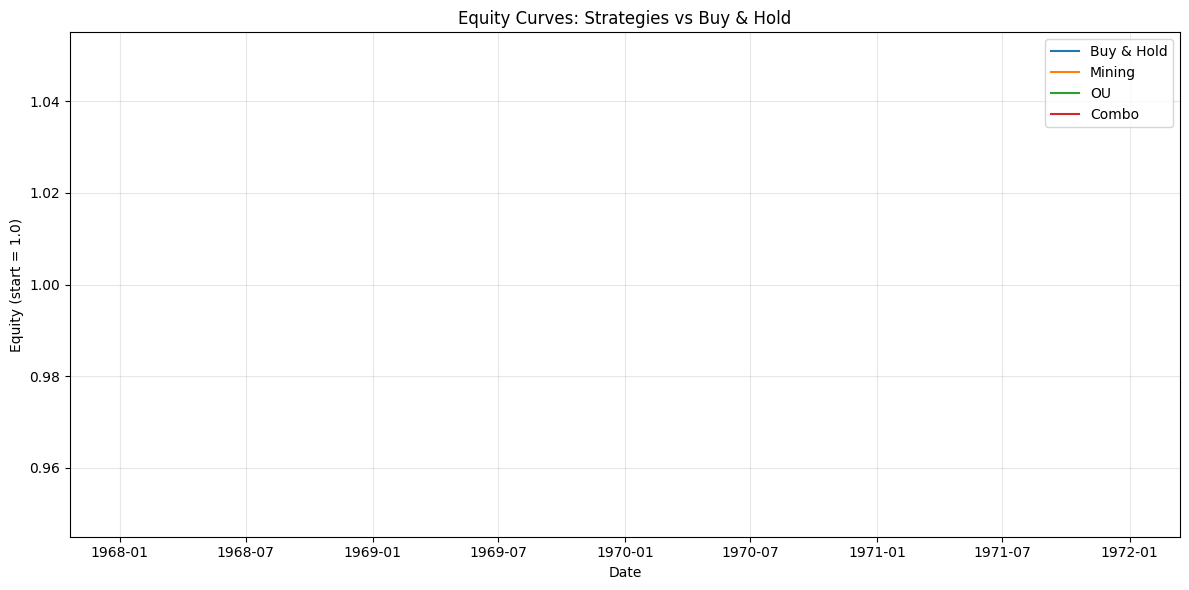

In [60]:
import matplotlib.pyplot as plt

curves = {
    "Buy & Hold": res_bh.equity,
    "Mining": res_mining.equity,
    "OU": res_ou.equity,
    "Combo": res_combo.equity,
}

plt.figure(figsize=(12, 6))
for name, eq in curves.items():
    plt.plot(eq.index, eq.values, label=name)

plt.title("Equity Curves: Strategies vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Equity (start = 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
